Creating RawArray with float64 data, n_channels=33, n_times=93955
    Range : 0 ... 93954 =      0.000 ...   183.504 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


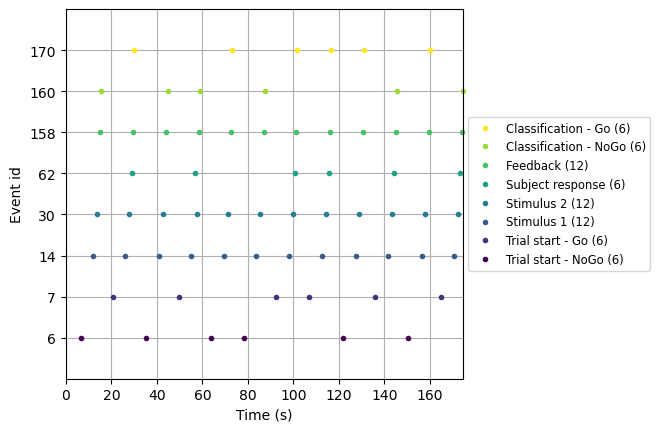

Not setting metadata
12 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 12 events and 2561 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=33, n_times=95747
    Range : 0 ... 95746 =      0.000 ...   187.004 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


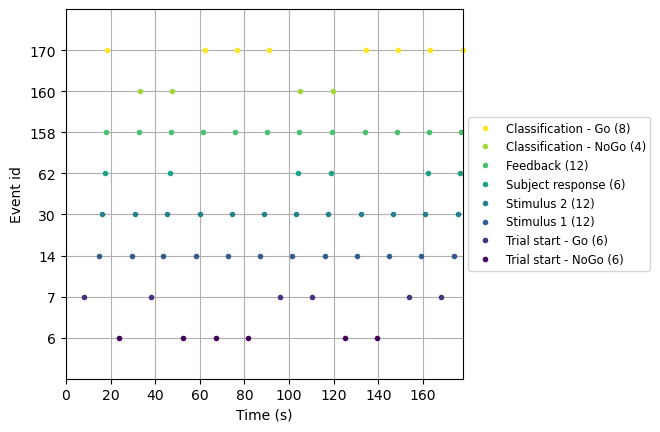

Not setting metadata
12 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 12 events and 2561 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=33, n_times=98299
    Range : 0 ... 98298 =      0.000 ...   191.988 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


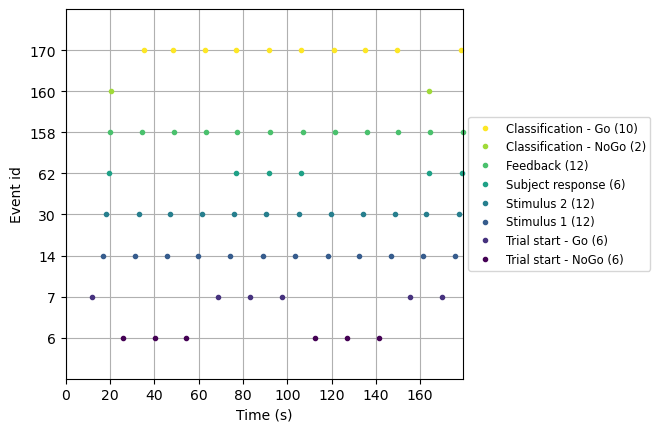

Not setting metadata
12 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 12 events and 2561 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=33, n_times=97534
    Range : 0 ... 97533 =      0.000 ...   190.494 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/var/folders/_0/_22pyjvn3s16kg6zx190bt1m0000gn/T/ipykernel_55496/1433042790.py:93: RuntimeWarning: event 0 missing from event_id will be ignored
  mne.viz.plot_events(events, sfreq=sfreq, color=color_dict, event_id=event_dict, on_missing='warn')


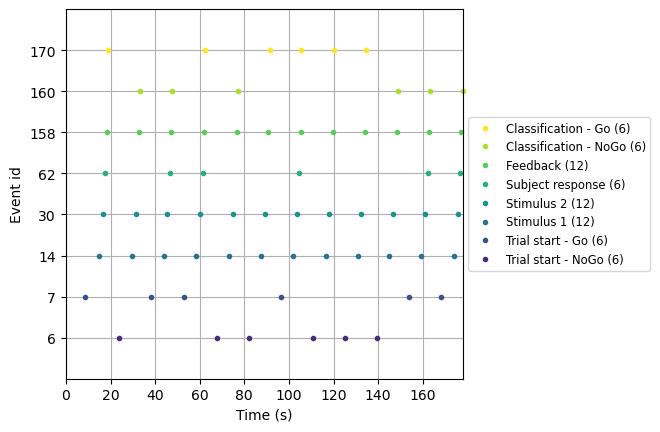

Not setting metadata
12 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 12 events and 2561 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=33, n_times=95744
    Range : 0 ... 95743 =      0.000 ...   186.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


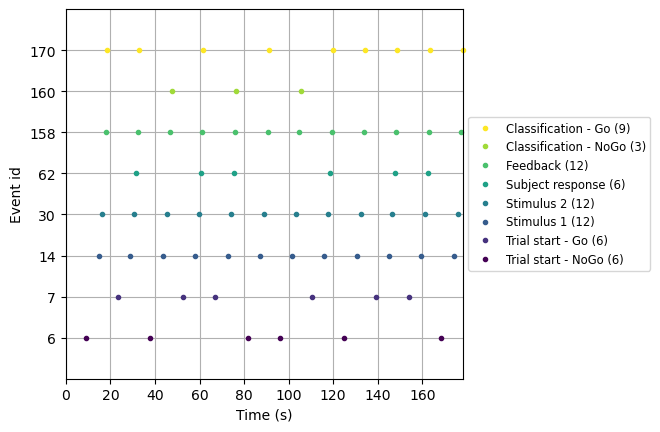

Not setting metadata
12 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 12 events and 2561 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=33, n_times=94718
    Range : 0 ... 94717 =      0.000 ...   184.994 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


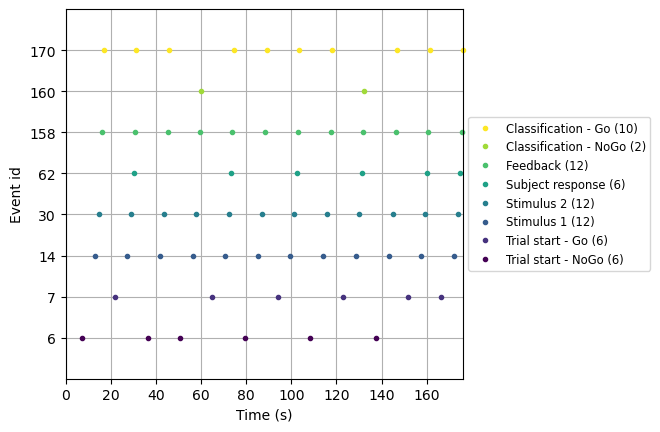

Not setting metadata
12 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 12 events and 2561 original time points ...
0 bad epochs dropped
Not setting metadata
36 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
36 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
72 matching events found
Applying baseline correction (mode: mean)
Need more than one channel to make topography for eeg. Disabling interactivity.


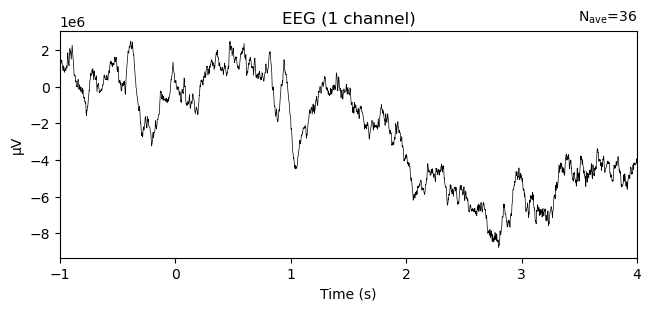

Need more than one channel to make topography for eeg. Disabling interactivity.


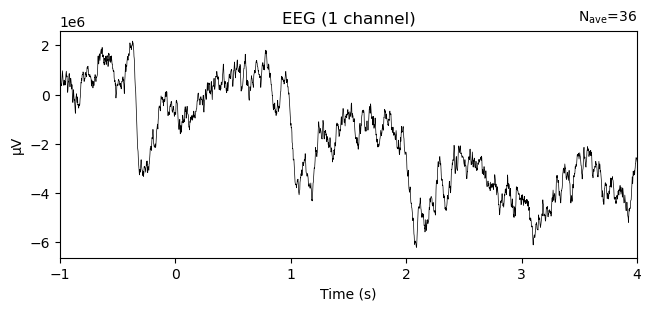

In [5]:
# Author: Minsu Zhang <minsuzhang@utexas.edu>

import mne
import numpy as np
import pyxdf
import os
from scipy.interpolate import interp1d
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
from pathlib import Path

from mne.filter import filter_data
from types import SimpleNamespace
import json

# Load XDF files iteratively from the folder
subject_name = 'tr1'
eeg_stream_name = "eegoSports 000103"
n_chan = 32

folder_name = Path.home() / ("/Users/jhpark/Desktop/VR-BCI-Cognitive-Training/data/sub-" + subject_name + "/ses-S002/eeg")
files = [f for f in os.listdir(folder_name) if f.endswith(".xdf")]

# Function to get stream indices based on name
def get_stream_indices(streams, name_data, name_trig):
    i_data, i_trig = -1, -1
    for i, stream in enumerate(streams):
        stream_name = stream['info']['name'][0]
        if name_data in stream_name:
            i_data = i
        if name_trig in stream_name:
            i_trig = i
    return i_data, i_trig

# Initialize lists for all epochs
all_go_epochs = []
all_nogo_epochs = []

for file in files:
    file_name = os.path.join(folder_name, file)
    streams, header = pyxdf.load_xdf(file_name)
    i_data, i_trig = get_stream_indices(streams, eeg_stream_name, 'UnityTriggerStream')

    # Extract EEG data
    data = np.array(streams[i_data]["time_series"]).T
    sfreq = float(streams[i_data]["info"]["nominal_srate"][0])
    data_times = np.array(streams[i_data]["time_stamps"])

    # Extract event markers and interpolate
    trig = np.array(streams[i_trig]["time_series"][:,0]).astype(int)
    trig_times = np.array(streams[i_trig]["time_stamps"])
    interp_func = interp1d(trig_times, trig.flatten(), kind='nearest', fill_value="extrapolate")
    trigger_resampled = interp_func(np.arange(len(data[0])) / sfreq + data_times[0])

    # Append the trigger channel to the EEG data
    data_with_trigger = np.vstack((data[0:n_chan, :], trigger_resampled))
    channel_names = [ch['label'][0] for ch in streams[i_data]['info']['desc'][0]['channels'][0]['channel'] if ch['type'][0] == 'EEG'] + ['TRIGGER']

    # Create MNE info and RawArray for EEG data with trigger channel
    info = mne.create_info(
        ch_names=channel_names,
        sfreq=sfreq,
        ch_types=n_chan*['eeg'] + ['stim']
    )
    raw_data = mne.io.RawArray(data_with_trigger, info)

    # Common average reference
    raw_data, ref_data = mne.set_eeg_reference(raw_data)
    
    # Manually create events array from trigger channel
    trig_diff = np.diff(trigger_resampled)
    events_indices = np.where(trig_diff != 0)[0] + 1
    events = np.column_stack((events_indices, np.zeros(len(events_indices)), trigger_resampled[events_indices].astype(int)))
    events = events.astype(int)
    
    # Plot events
    unique_events = np.unique(events[:, 2])
    event_colors = dict(zip(unique_events, plt.cm.viridis(np.linspace(0, 1, len(unique_events)))))
    event_dict = {
        "Trial start - NoGo": 6,
        "Trial start - Go": 7,
        "Stimulus 1": 14,
        "Stimulus 2": 30,
        "Subject response": 62,
        "Feedback": 158,
        "Classification - NoGo": 160,
        "Classification - Go": 170
    }
    color_dict = {event: color for event, color in zip(unique_events, plt.cm.viridis(np.linspace(0, 1, len(unique_events))))}
    mne.viz.plot_events(events, sfreq=sfreq, color=color_dict, event_id=event_dict, on_missing='warn')
    
    # Create epochs for event_id 14
    epochs = mne.Epochs(
        raw_data,
        events,
        event_id={"Stimulus 1": 14},
        tmin=-1.0,
        tmax=4.0,
        baseline=(None, 0),
        preload=True)

    # Identify trials where event 14 follows a 7 (Go) or 6 (NoGo)
    go_trials = [i for i in range(len(events) - 1) if events[i, 2] == 7 and events[i + 1, 2] == 14]
    nogo_trials = [i for i in range(len(events) - 1) if events[i, 2] == 6 and events[i + 1, 2] == 14]
    go_trials = [epochs.selection.tolist().index(i + 1) for i in go_trials if i + 1 in epochs.selection]
    nogo_trials = [epochs.selection.tolist().index(i + 1) for i in nogo_trials if i + 1 in epochs.selection]
    go_epochs = epochs[go_trials] # (n_trials x n_channels x n_samples)
    nogo_epochs = epochs[nogo_trials]
    all_go_epochs.append(go_epochs)
    all_nogo_epochs.append(nogo_epochs)

# Concatenate all epochs
all_go_epochs = mne.concatenate_epochs(all_go_epochs)
all_nogo_epochs = mne.concatenate_epochs(all_nogo_epochs)
go_labels = np.repeat(170, len(all_go_epochs))
nogo_labels = np.repeat(160, len(all_nogo_epochs))
labels = np.concatenate((go_labels, nogo_labels))
epochs = mne.concatenate_epochs((all_go_epochs, all_nogo_epochs))

# Plot the averages
go_evoked = all_go_epochs.average()
nogo_evoked = all_nogo_epochs.average()
evoked = epochs.average()
fig_go = go_evoked.plot(picks=['CZ']) 
fig_nogo = nogo_evoked.plot(picks=['CZ']) 
plt.show()